In [26]:
from ipywidgets import widgets
from IPython.display import display
from tensorflow import keras
from tensorflow.keras import layers
import make_dataset
import os
import glob
import numpy as np
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
import matplotlib.axes as ax

In [27]:
#import matplotlib
#gui_env = [i for i in matplotlib.rcsetup.interactive_bk]
#non_gui_backends = matplotlib.rcsetup.non_interactive_bk
#print ("Non Gui backends are:", non_gui_backends)
#print ("Gui backends I will test for", gui_env)
#for gui in gui_env:
#    print ("testing", gui)
#    try:
#        matplotlib.use(gui,warn=False, force=True)
#        from matplotlib import pyplot as plt
#        print ("    ",gui, "Is Available")
#        plt.plot([1.5,2.0,2.5])
#        fig = plt.gcf()
#        fig.suptitle(gui)
#        plt.show()
#        print ("Using ..... ",matplotlib.get_backend())
#    except:
#        print ("    ",gui, "Not found")

In [28]:
latent_dim = 4

In [29]:
#make model
class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(32, 300, 1))
x = layers.Conv2D(64, (2,3), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, (2,3), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16*latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, 
                         kernel_initializer='zeros',
                         name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 75 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((8, 75, 128))(x)
x = layers.Conv2DTranspose(64, (2,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, (2,3), activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='relu', padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
#decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

vae = VAE(encoder, decoder)
vae.compile()

In [46]:
#load latest weights
list_of_files = glob.glob(os.path.join(os.getcwd(),'checkpoint_latdim{}'.format(latent_dim),'*'))
weights_fname = max(list_of_files, key=os.path.getmtime)
print(weights_fname)
vae.built = True;
vae.load_weights(weights_fname) 

/Users/gws584/Python/VAE_keras/checkpoint_latdim4/weights_epoch_494.h5


In [47]:
dim_sliders = list()

for i in range(latent_dim):
    dim_sliders.append(widgets.FloatSlider(
        value = 0,
        min = -4.0,
        max = 4.0,
        step = 0.1,
        continuous_update = False,
        description = 'Dim {}'.format(i+1),
        orientation = 'horizontal'))

slider_box = widgets.HBox(dim_sliders)   

In [48]:
def on_value_change(change):
    z = list()
    for i in range(latent_dim):
        z.append(dim_sliders[i].value)
    z = np.array(z)
    print(z)
    update_image(z)
        
for i in range(latent_dim):
    dim_sliders[i].observe(on_value_change, names='value')

In [49]:
def update_image(z):
    input_tensor = tf.constant(z, shape=[1,latent_dim])
    new_data = vae.decoder.predict(input_tensor)
    (_,r,c,_) = new_data.shape
    new_data = new_data.reshape([r,c])

    #image = PIL.Image.fromarray(new_data,'L')
    f = plt.figure(figsize = [18,4])
    cur_axis = f.add_axes([0,0,1,1])
    cur_axis.set_axis_off()
    cur_axis.imshow(new_data)
    f.show()

<ipython-input-49-c253ad76bf91>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


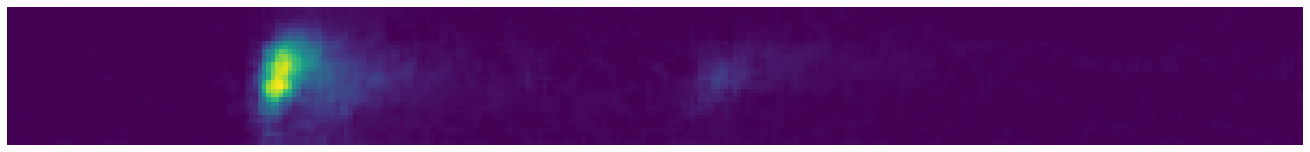

In [50]:
#set initial state
display(slider_box)
z = list()
for i in range(latent_dim):
    z.append(dim_sliders[i].value)
z = np.array(z)
update_image(z)

In [51]:
dataset_dir = 'RGCtypes_1887'
[train_set, test_set] = make_dataset.load_dataset_no_labels(dataset_dir)

Found 1761 files belonging to 1 classes.
Found 126 files belonging to 1 classes.


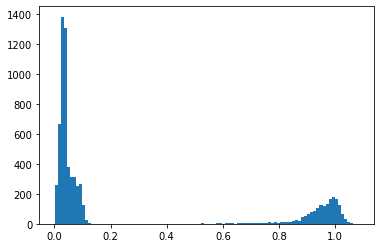

In [52]:
z_mean,z_logvar,_ = vae.encoder.predict(train_set)
plt.hist(np.exp(z_logvar).flatten(),bins=100)
plt.show()

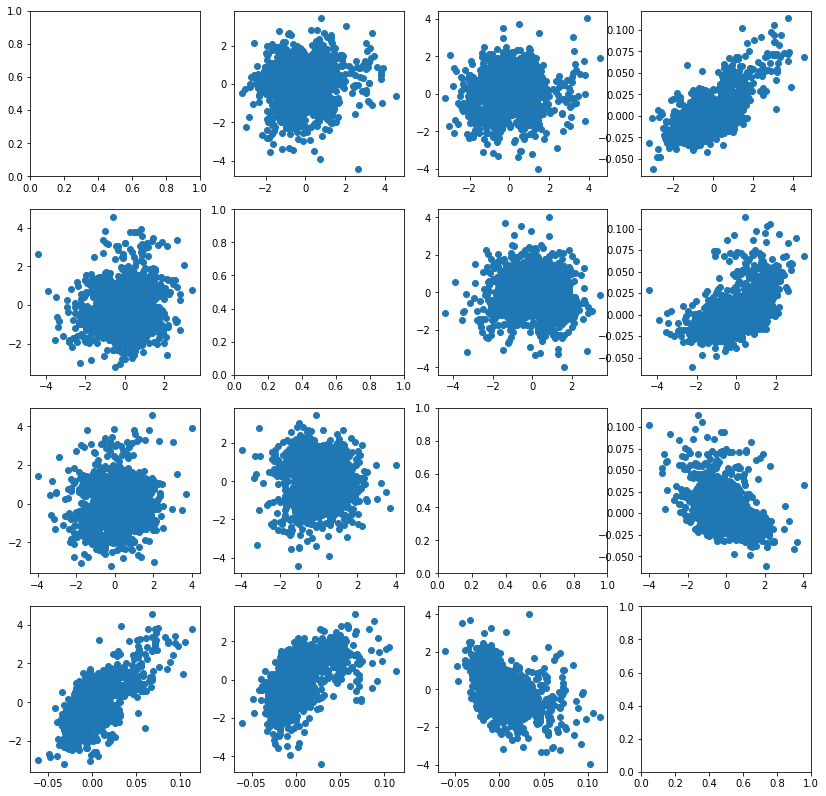

In [53]:
plt.figure(figsize=(14, 14))
ind = 1
for i in range(latent_dim):
    for j in range(latent_dim):
        plt.subplot(latent_dim,latent_dim,ind)
        if not i == j:
            plt.scatter(z_mean[:, i], z_mean[:, j])            
        ind=ind+1
plt.show()